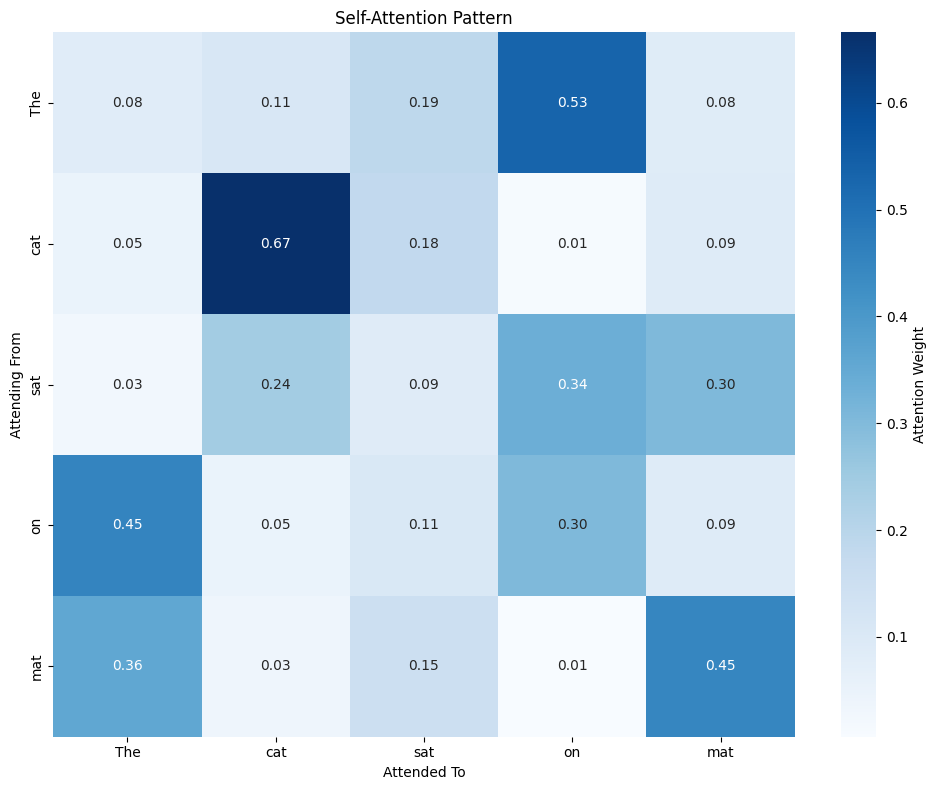

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(attention_weights, tokens):
    """
    Visualize attention weights as a heatmap.
    
    Args:
        attention_weights: (seq_len, seq_len) tensor
        tokens: list of token strings
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        attention_weights.detach().numpy(),
        xticklabels=tokens,
        yticklabels=tokens,
        cmap='Blues',
        annot=True,
        fmt='.2f',
        cbar_kws={'label': 'Attention Weight'}
    )
    plt.xlabel('Attended To')
    plt.ylabel('Attending From')
    plt.title('Self-Attention Pattern')
    plt.tight_layout()
    plt.show()

# Example usage
tokens = ["The", "cat", "sat", "on", "mat"]
# Simulated attention weights (in practice, these come from your model)
attn = torch.softmax(torch.randn(5, 5), dim=-1)
visualize_attention(attn, tokens)

In [2]:
import torch
import torch.nn.functional as F

# Create simple input: 3 words, 8-dimensional embeddings
seq_len, d_model = 3, 8
X = torch.randn(seq_len, d_model)

# Initialize projection matrices
d_k = 4  # Smaller dimension for Q and K
W_Q = torch.randn(d_model, d_k)
W_K = torch.randn(d_model, d_k)
W_V = torch.randn(d_model, d_k)

# Step 1: Create Q, K, V
Q = X @ W_Q  # (3, 4)
K = X @ W_K  # (3, 4)
V = X @ W_V  # (3, 4)

print("Query matrix shape:", Q.shape)
print("Key matrix shape:", K.shape)
print("Value matrix shape:", V.shape)

# Step 2: Compute attention scores
scores = Q @ K.T  # (3, 3)
print("\nRaw attention scores:")
print(scores)

# Step 3: Scale by sqrt(d_k)
scaled_scores = scores / (d_k ** 0.5)
print("\nScaled scores:")
print(scaled_scores)

# Step 4: Apply softmax
attention_weights = F.softmax(scaled_scores, dim=-1)
print("\nAttention weights (each row sums to 1):")
print(attention_weights)
print("Row sums:", attention_weights.sum(dim=-1))  # Should be [1, 1, 1]

# Step 5: Weighted sum of values
output = attention_weights @ V  # (3, 4)
print("\nFinal output shape:", output.shape)

Query matrix shape: torch.Size([3, 4])
Key matrix shape: torch.Size([3, 4])
Value matrix shape: torch.Size([3, 4])

Raw attention scores:
tensor([[-12.3636,  -1.7922,   6.2182],
        [-23.9975,  -9.4952,  19.3009],
        [  2.6162,   1.5306,  -3.3092]])

Scaled scores:
tensor([[ -6.1818,  -0.8961,   3.1091],
        [-11.9987,  -4.7476,   9.6505],
        [  1.3081,   0.7653,  -1.6546]])

Attention weights (each row sums to 1):
tensor([[9.0602e-05, 1.7893e-02, 9.8202e-01],
        [3.9616e-10, 5.5848e-07, 1.0000e+00],
        [6.1245e-01, 3.5590e-01, 3.1651e-02]])
Row sums: tensor([1.0000, 1.0000, 1.0000])

Final output shape: torch.Size([3, 4])


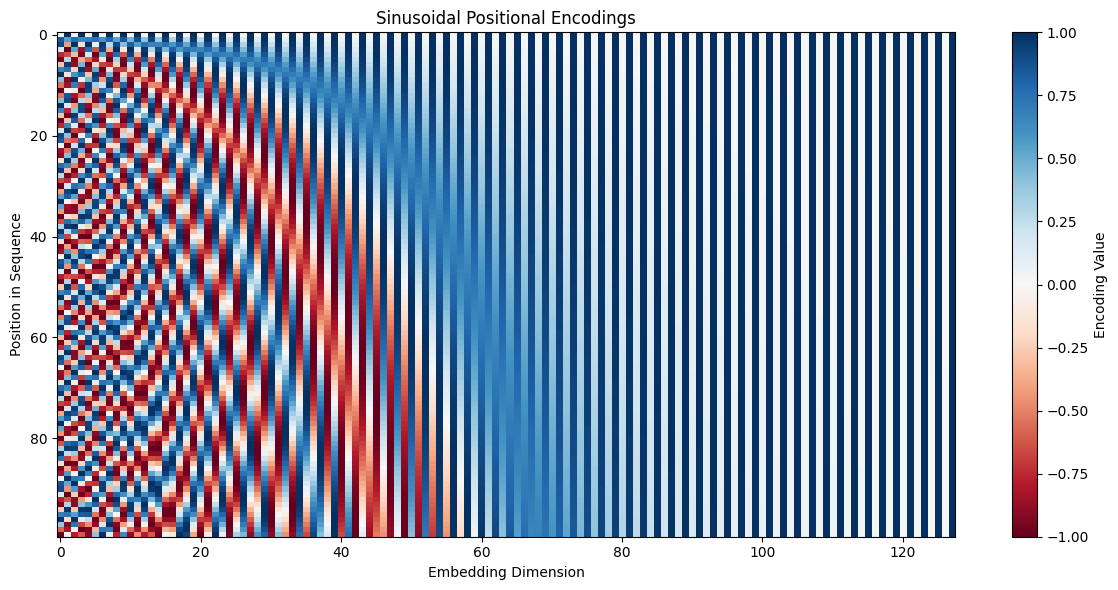

Position 0 encoding (first 8 dims): tensor([0., 1., 0., 1., 0., 1., 0., 1.])
Position 1 encoding (first 8 dims): tensor([0.8415, 0.5403, 0.7617, 0.6479, 0.6816, 0.7318, 0.6047, 0.7965])
Position 50 encoding (first 8 dims): tensor([-0.2624,  0.9650, -0.6320,  0.7750, -0.2030,  0.9792,  0.8690,  0.4948])


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def generate_positional_encoding(max_len, d_model):
    """
    Generate sinusoidal positional encodings.
    
    Args:
        max_len: maximum sequence length
        d_model: embedding dimension
    
    Returns:
        PE: (max_len, d_model) positional encoding matrix
    """
    PE = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)  # (max_len, 1)
    
    # Create the div_term: 10000^(2i/d_model)
    div_term = torch.exp(
        torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model)
    )
    
    # Apply sin to even indices
    PE[:, 0::2] = torch.sin(position * div_term)
    
    # Apply cos to odd indices
    PE[:, 1::2] = torch.cos(position * div_term)
    
    return PE

# Generate encodings
max_len, d_model = 100, 128
PE = generate_positional_encoding(max_len, d_model)

# Visualize
plt.figure(figsize=(12, 6))
plt.imshow(PE.numpy(), cmap='RdBu', aspect='auto')
plt.colorbar(label='Encoding Value')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position in Sequence')
plt.title('Sinusoidal Positional Encodings')
plt.tight_layout()
plt.show()

# Show how encodings differ for different positions
print("Position 0 encoding (first 8 dims):", PE[0, :8])
print("Position 1 encoding (first 8 dims):", PE[1, :8])
print("Position 50 encoding (first 8 dims):", PE[50, :8])

In [4]:
import torch

def create_causal_mask(seq_len):
    """
    Create a causal mask for autoregressive modeling.
    Lower triangular matrix: position i can only attend to j <= i
    """
    mask = torch.tril(torch.ones(seq_len, seq_len))
    return mask

def create_padding_mask(lengths, max_len):
    """
    Create padding mask for sequences of different lengths.
    
    Args:
        lengths: list of actual sequence lengths
        max_len: padded sequence length
    
    Returns:
        mask: (batch_size, max_len) where 1 = real token, 0 = padding
    """
    batch_size = len(lengths)
    mask = torch.zeros(batch_size, max_len)
    
    for i, length in enumerate(lengths):
        mask[i, :length] = 1
    
    return mask

# Example: Causal mask for sequence length 5
causal_mask = create_causal_mask(5)
print("Causal Mask (1 = can attend, 0 = cannot attend):")
print(causal_mask.int())

# Example: Padding mask for batch
lengths = [3, 5, 2]  # Actual lengths
max_len = 5
padding_mask = create_padding_mask(lengths, max_len)
print("\nPadding Mask (1 = real token, 0 = padding):")
print(padding_mask.int())

# How to apply masks in attention
def masked_attention_example(scores, mask):
    """
    Apply mask to attention scores before softmax.
    Masked positions get -inf, so softmax makes them ~0
    """
    # scores: (seq_len, seq_len)
    # mask: (seq_len, seq_len) with 1s and 0s
    
    masked_scores = scores.masked_fill(mask == 0, float('-inf'))
    attention = torch.softmax(masked_scores, dim=-1)
    
    # Replace any NaN (from -inf) with 0
    attention = attention.nan_to_num(0)
    
    return attention

# Test it
scores = torch.randn(5, 5)
causal_mask = create_causal_mask(5)
masked_attn = masked_attention_example(scores, causal_mask)

print("\nCausal Attention Weights:")
print(masked_attn)
print("\nNotice: Each row only has non-zero weights for current and previous positions!")

Causal Mask (1 = can attend, 0 = cannot attend):
tensor([[1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1]], dtype=torch.int32)

Padding Mask (1 = real token, 0 = padding):
tensor([[1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0]], dtype=torch.int32)

Causal Attention Weights:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2540, 0.7460, 0.0000, 0.0000, 0.0000],
        [0.4528, 0.3913, 0.1559, 0.0000, 0.0000],
        [0.3013, 0.1623, 0.0439, 0.4925, 0.0000],
        [0.2754, 0.1305, 0.2013, 0.3542, 0.0387]])

Notice: Each row only has non-zero weights for current and previous positions!


In [5]:
import torch
import torch.nn as nn

class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, d_k):
        super().__init__()
        self.W_Q = nn.Linear(d_model, d_k)
        self.W_K = nn.Linear(d_model, d_k)
        self.W_V = nn.Linear(d_model, d_k)
        self.scale = d_k ** 0.5
        
    def forward(self, x):
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)
        
        scores = Q @ K.transpose(-2, -1) / self.scale
        attn = torch.softmax(scores, dim=-1)
        return attn @ V

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.W_O = nn.Linear(d_model, d_model)
        self.scale = self.d_k ** 0.5
        
    def forward(self, x):
        batch, seq_len, d_model = x.shape
        
        # Project and reshape into multiple heads
        Q = self.W_Q(x).view(batch, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_K(x).view(batch, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_V(x).view(batch, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        # Compute attention for all heads in parallel
        scores = Q @ K.transpose(-2, -1) / self.scale
        attn = torch.softmax(scores, dim=-1)
        out = attn @ V
        
        # Concatenate heads and project
        out = out.transpose(1, 2).contiguous().view(batch, seq_len, d_model)
        return self.W_O(out)

# Compare parameter counts
d_model = 512
single_head = SingleHeadAttention(d_model, d_model)
multi_head = MultiHeadAttention(d_model, num_heads=8)

single_params = sum(p.numel() for p in single_head.parameters())
multi_params = sum(p.numel() for p in multi_head.parameters())

print(f"Single-head parameters: {single_params:,}")
print(f"Multi-head parameters: {multi_params:,}")
print(f"Multi-head has {multi_params/single_params:.2f}x more parameters")

# Test forward pass
batch_size, seq_len = 2, 10
x = torch.randn(batch_size, seq_len, d_model)

single_out = single_head(x)
multi_out = multi_head(x)

print(f"\nSingle-head output shape: {single_out.shape}")
print(f"Multi-head output shape: {multi_out.shape}")
print("\nBoth produce same-shaped outputs, but multi-head learns richer patterns!")

Single-head parameters: 787,968
Multi-head parameters: 1,050,624
Multi-head has 1.33x more parameters

Single-head output shape: torch.Size([2, 10, 512])
Multi-head output shape: torch.Size([2, 10, 512])

Both produce same-shaped outputs, but multi-head learns richer patterns!
